
The R0 is between 2 and 6, meaning each infected person infects 2–6 others, which can cause the number of infected to double every few days.

In [ ]:

# https://informationisbeautiful.net/visualizations/covid-19-coronavirus-infographic-datapack/
# https://docs.google.com/spreadsheets/d/1g_YxmDfQx7aOU2DKzNZo9b-NTk62Bju6X3z6OuCa6gw/edit#gid=515684451

In [ ]:

command_str = '{sys.executable} -m pip install --upgrade statsmodels'.format(sys=sys)
print(command_str)
!{command_str}

In [1]:

import sys

# Insert at 1, 0 is the script path (or '' in REPL)
sys.path.insert(1, '../py')

In [2]:

%run ../../load_magic/storage.py
%run ../../load_magic/paths.py
%run ../../load_magic/lists.py
%run ../../load_magic/environment.py
%run ../../load_magic/dataframes.py

import scraping_utils
wikipedia = scraping_utils.wikipedia

from bs4 import BeautifulSoup as bs
import networkx as nx
import re
import urllib.request

notebook_path = get_notebook_path()
print(notebook_path)
s = Storage()
#pandemic_df = s.load_object('pandemic_df')
print(['s.{}'.format(fn) for fn in dir(s) if not fn.startswith('_')])

%pprint
dir()

D:\Documents\Repositories\notebooks\covid19\ipynb\Corona Virus Exploration.ipynb
['s.attempt_to_pickle', 's.data_csv_folder', 's.data_folder', 's.encoding_type', 's.load_csv', 's.load_dataframes', 's.load_object', 's.save_dataframes', 's.saves_csv_folder', 's.saves_folder', 's.saves_pickle_folder', 's.store_objects']
Pretty printing has been turned OFF


['Config', 'In', 'Out', 'RandomForestClassifier', 'SequenceMatcher', 'Storage', '_', '__', '___', '__builtin__', '__builtins__', '__doc__', '__loader__', '__name__', '__nonzero__', '__package__', '__spec__', '_dh', '_i', '_i1', '_i2', '_ih', '_ii', '_iii', '_oh', 'bs', 'check_4_doubles', 'check_for_typos', 'conjunctify_list', 'copyfile', 'csv', 'encoding', 'example_iterrows', 'exit', 'filepath_regex', 'get_classifier', 'get_column_descriptions', 'get_data_structs_dataframe', 'get_datastructure_prediction', 'get_dir_tree', 'get_git_lfs_track_commands', 'get_importances', 'get_input_sample', 'get_ipython', 'get_max_rsquared_adj', 'get_module_version', 'get_notebook_path', 'get_page_tables', 'get_specific_gitignore_files', 'get_struct_name', 'humanize_bytes', 'io', 'ipykernel', 'json', 'jupyter_config_dir', 'math', 'notebook_path', 'notebookapp', 'nx', 'os', 'pd', 'pickle', 'plt', 'preprocess_data', 'print_all_files_ending_starting_with', 'print_all_files_ending_with', 'print_all_files_st

In [ ]:

!start %windir%\explorer.exe "{os.path.abspath(os.path.dirname(notebook_path))}"

In [ ]:

for file_name in os.listdir(s.saves_pickle_folder):
    if file_name.endswith('_df.pickle'):
        df_name = file_name.split('.')[0]
        print("{} = s.load_object('{}')".format(df_name, df_name))
        print("{}".format(df_name))

In [3]:

asian_list = ['south_korea_df', 'hong_kong_df', 'japan_df', 'thailand_df', 'malaysia_df', 'china_df', 'vietnam_df',
              'singapore_df', 'philippines_df']
cumulative_list = ['china_df', 'czech_df', 'germany_df', 'hong_kong_df', 'iran_df', 'italy_df', 'japan_df', 'netherlands_df',
                   'singapore_df', 'slovakia_df', 'south_korea_df', 'spain_df', 'uk_df', 'usa_df']

In [7]:

countries_list = []
for df_name in set(asian_list + cumulative_list):
    df = s.load_object(df_name)
    for cn in df.columns:
        if 'test' in cn.lower():
            state_name = ' '.join(df_name[:-3].split('_')).title()
            countries_list.append(state_name)
            break
conjunctify_list(countries_list)

'Uk, Italy, Japan, Spain, Czech, Slovakia, and South Korea'

In [11]:

confirm_set = set()
cumulative_set = set()
new_set = set()
union_set = set()
intersection_set = set(['Confirmed_New', 'Date'])
for df_name in set(asian_list + cumulative_list):
    df = s.load_object(df_name)
    df_set = set()
    for cn in df.columns:
        df_set.add(cn)
        if 'confirm' in cn.lower():
            confirm_set.add(cn)
        if 'cumul' in cn.lower():
            cumulative_set.add(cn)
        if 'new' in cn.lower():
            new_set.add(cn)
    intersection_set = intersection_set.intersection(df_set)
    union_set = union_set.union(df_set)
intersection_set

{'Confirmed_New', 'Date'}

In [12]:

new_set

{'Confirmed_New', 'Deaths_New', 'Tested_New', 'Recovered_New'}

In [13]:

cumulative_set

{'Recovered_Cumulative', 'Deaths_Cumulative', 'Discharged_Cumulative', 'ICU_Cumulative', 'Active_Cumulative', 'Tested_Cumulative', 'Confirmed_Cumulative', 'Repatriated_Cumulative', 'Abroad_Cumulative'}

In [14]:

confirm_set

{'Confirmed_Cumulative', 'Confirmed_Repatriated', 'Confirmed_New'}

In [519]:

from datetime import date

def merge_dfs(merge_df, df_name, column_name='Confirmed_New'):
    df = s.load_object(df_name)
    if column_name in df.columns:
        mask_series = (df[column_name] >= after_cases)
        if df[mask_series].shape[0] > 0:
            df.Date = df.Date.map(lambda ts: date(ts.year, ts.month, ts.day))
            df.set_index('Date', drop=True, inplace=True)
            country_suffix = '_{}'.format(df_name[:-3])
            columns_list = [column_name]
            merge_df = merge_df.merge(df[columns_list], how='outer', left_index=True, right_index=True,
                                      suffixes=('_merge', country_suffix))
            if merge_df.index.has_duplicates:
                raise RuntimeError('{} has duplicates'.format(df_name))
            columns_list = merge_df.columns.tolist()
            columns_list[-1] = columns_list[-1] + country_suffix
            merge_df.columns = columns_list
    
    return merge_df

In [528]:

merge_df = pd.DataFrame([])
plotted_variable = 'Deaths_New'
after_cases = 10
for df_name in set(asian_list + cumulative_list):
    merge_df = merge_dfs(merge_df, df_name, plotted_variable)

In [543]:

merge_df = pd.DataFrame([])
plotted_variable = 'Confirmed_Cumulative'
after_cases = 100
for df_name in cumulative_list:
    merge_df = merge_dfs(merge_df, df_name, plotted_variable)

In [1]:

confirms_list = merge_df.columns.tolist()
confirms_list

NameError: name 'merge_df' is not defined

In [545]:

for column_name in confirms_list:
    merge_df[column_name] = merge_df[column_name].map(lambda x: re.sub('[^\d]+', '', str(x)))
    merge_df[column_name] = pd.to_numeric(merge_df[column_name], errors='coerce')
    mask_series = (merge_df[column_name] >= after_cases)
    ts0 = merge_df[mask_series].index.min()
    new_name = '{}_day'.format(column_name[len(plotted_variable)+1:])
    merge_df[new_name] = (merge_df.index - ts0).days

In [546]:

day_merge_df = pd.DataFrame([])
def create_day_df(column_name):
    new_name = '{}_day'.format(column_name[len(plotted_variable)+1:])
    columns_list = [new_name, column_name]
    df = pd.DataFrame(merge_df[columns_list].values, columns=columns_list, index=merge_df.index)
    df.set_index(new_name, drop=True, inplace=True)
    df.columns = [' '.join(cn[len(plotted_variable)+1:].split('_')).title() for cn in df.columns]
    
    return df
for column_name in confirms_list:
    day_merge_df = day_merge_df.merge(create_day_df(column_name), how='outer', left_index=True,
                                      right_index=True, suffixes=('_merge', '_{}'.format(column_name)))
day_merge_df.interpolate(axis='index', limit_area='inside', inplace=True)
day_merge_df

,Czech,Germany,Iran,Italy,Japan,Slovakia,South Korea,Spain,Uk,Usa
-50.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-46.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-45.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-42.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-41.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
51.0,NaN,NaN,NaN,NaN,10540.0,NaN,89610.0,NaN,NaN,526720.0
52.0,NaN,NaN,NaN,NaN,10990.0,NaN,90370.0,NaN,NaN,620890.0
53.0,NaN,NaN,NaN,NaN,11370.0,NaN,91370.0,NaN,NaN,NaN
54.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [187]:

country_populations_df = s.load_object('country_populations_df')
sorted(country_populations_df.index.tolist())

['Abkhazia', 'Afghanistan', 'Albania', 'Algeria', 'American Samoa (US)', 'Andorra', 'Angola', 'Anguilla (UK)', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Artsakh', 'Aruba (Netherlands)', 'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain', 'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bermuda (UK)', 'Bhutan', 'Bolivia', 'Bosnia and Herzegovina', 'Botswana', 'Brazil', 'British Virgin Islands (UK)', 'Brunei', 'Bulgaria', 'Burkina Faso', 'Burundi', 'Cambodia', 'Cameroon', 'Canada', 'Cape Verde', 'Cayman Islands (UK)', 'Central African Republic', 'Chad', 'Chile', 'China', 'Christmas Island (Australia)', 'Cocos (Keeling) Islands (Australia)', 'Colombia', 'Comoros', 'Congo', 'Cook Islands (NZ)', 'Costa Rica', 'Croatia', 'Cuba', 'Curaçao (Netherlands)', 'Cyprus', 'Czech Republic', 'DR Congo', 'Denmark', 'Djibouti', 'Dominica', 'Dominican Republic', 'East Timor', 'Ecuador', 'Egypt', 'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia', 'Eswatini', 'Ethiopi

In [169]:

file_name = '20200326-sitrep-66-covid-19.csv'
file_path = os.path.join(s.data_csv_folder, file_name)
kwargs = {'20200326-sitrep-66-covid-19': '20200326-sitrep-66-covid-19'}
MAR26_df = s.load_dataframes(**kwargs)['20200326-sitrep-66-covid-19']

Attempting to load D:\Documents\Repositories\notebooks\covid19\saves\pickle\20200326-sitrep-66-covid-19.pickle.
No pickle exists - attempting to load D:\Documents\Repositories\notebooks\covid19\saves\csv\20200326-sitrep-66-covid-19.csv.
No csv exists - trying D:\Documents\Repositories\notebooks\covid19\data\csv\20200326-sitrep-66-covid-19.csv.


In [172]:

MAR26_df.columns = ['Country', 'Confirmed_Cumulative', 'Confirmed_New', 'Deaths_Cumulative', 'Deaths_New',
                    'Transmission_Classification', 'Days_Since_Last']
MAR26_df.set_index('Country', drop=True, inplace=True)
MAR26_df

,Confirmed_Cumulative,Confirmed_New,Deaths_Cumulative,Deaths_New,Transmission_Classification,Days_Since_Last
Country,,,,,,
China,81961,113,3293,6,Local transmission,0
Republic of Korea,9241,104,131,5,Local transmission,0
Australia,2799,547,11,3,Local transmission,0
Malaysia,1796,172,19,3,Local transmission,0
Japan,1291,98,45,2,Local transmission,0
...,...,...,...,...,...,...
Niger,2,0,0,0,Imported cases only,2
Zimbabwe,2,0,1,0,Imported cases only,4
Réunion,94,11,0,0,Local transmission,0


In [226]:

new_value = 'Saint Barthélemy (France)'
old_value = 'Saint Barthélemy'
as_list = MAR26_df.index.tolist()
if old_value in as_list:
    idx = as_list.index(old_value)
    as_list[idx] = new_value
    MAR26_df.index = as_list
set(MAR26_df.index.tolist()) - set(country_populations_df.index.tolist())

{'Diamond Princess', 'Martinique', 'Réunion', 'Mayotte', 'Guadeloupe', 'French Guiana', 'occupied Palestinian territory', 'Holy See'}

In [551]:

mask_series = (day_merge_df.index == 10.0)
day_merge_df[mask_series]

,Czech,Germany,Iran,Italy,Japan,Slovakia,South Korea,Spain,Uk,Usa
10.0,3830.0,3490.0,15010.0,20360.0,266.666667,7200.0,275.0,3650.0,870.0,129.333333


In [566]:

columns_list = ['Czech Republic', 'Germany', 'Iran', 'Italy', 'Japan', 'Slovakia', 'South Korea', 'Spain', 'United Kingdom', 'United States']
days_df = day_merge_df.copy()
days_df.columns = columns_list
days_df = days_df.T

In [567]:

mask_series = (country_populations_df.index.isin(days_df.index))
columns_list = ['Population']
for country_name, row_series in country_populations_df[mask_series][columns_list].iterrows():
    population = row_series['Population']
    mask_series = (days_df.index == country_name)
    for days_country_name, days_row_series in days_df[mask_series].iterrows():
        for column_name, column_value in days_row_series.iteritems():
            if str(column_value) != 'nan':
                days_df.loc[days_country_name, column_name] = column_value/population

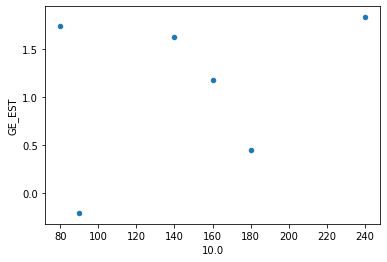

In [541]:

days_list = [10.0]
columns_list = ['GE_EST']
AxesSubplot_obj = days_df[days_list].merge(gdp_df[columns_list], how='inner', left_index=True,
                                           right_index=True, suffixes=('_days',
                                                                       '_gdp')).plot.scatter(x=10.0,
                                                                                             y='GE_EST')

In [568]:

day_merge_df = days_df.copy().T

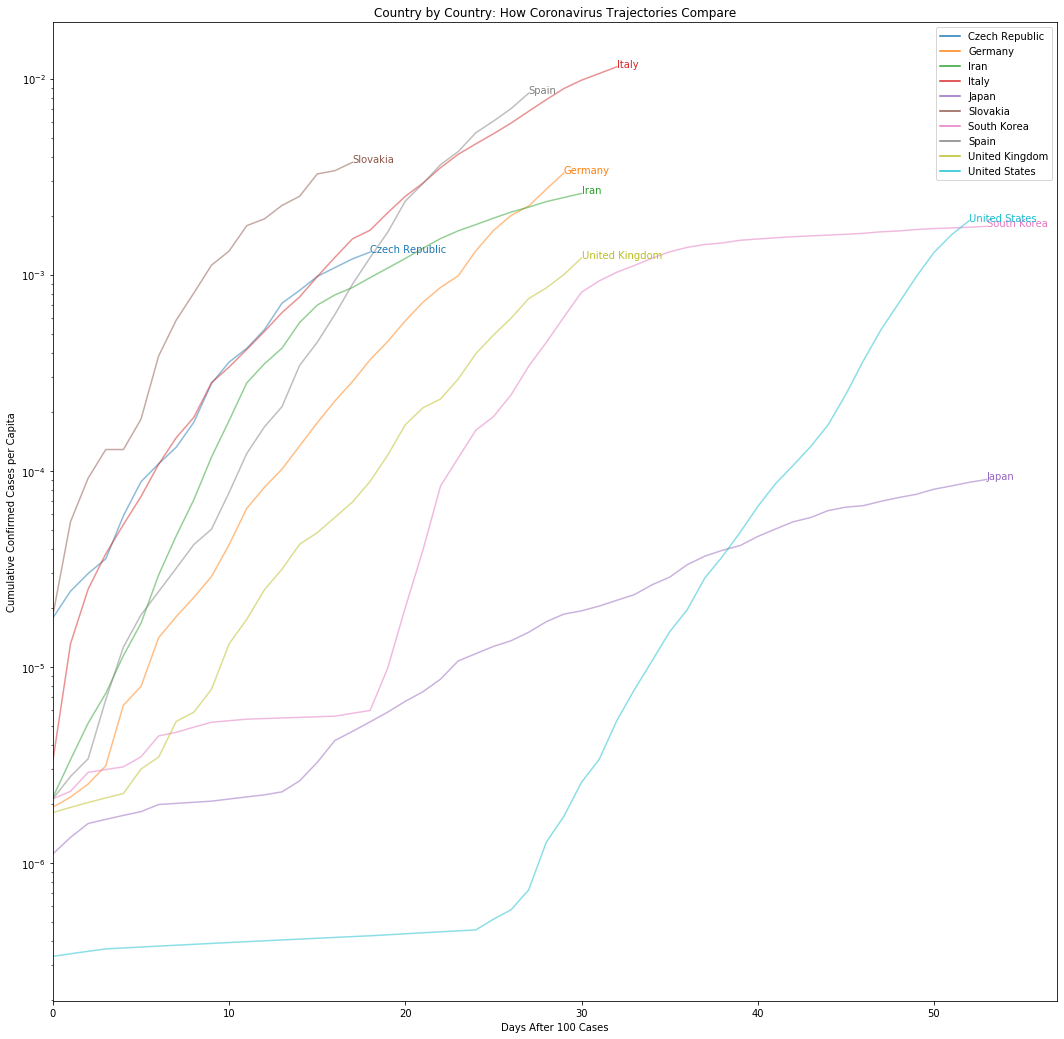

In [572]:

import math

fig, ax = plt.subplots(figsize=(18, 18))
ax.set_yscale('log')
ax.set_xlim(left=0, right=day_merge_df.index.max()+2)
ax.set_ylabel('Cumulative Confirmed Cases')
ax.set_xlabel('Days After {} Cases'.format(after_cases))
ax.set_title('Country by Country: How Coronavirus Trajectories Compare')
mask_series = (day_merge_df.index >= 0)
p = day_merge_df[mask_series].plot
AxesSubplot_obj = p.line(ax=ax)
Line2D_obj_list = [Line2D_obj for Line2D_obj in AxesSubplot_obj.get_lines()]
columns_list = day_merge_df.columns.tolist()
for cn, Line2D_obj in zip(columns_list, Line2D_obj_list):
    cn_series = day_merge_df[mask_series][cn]
    cn_series.dropna(inplace=True)
    x = cn_series.index[-1]
    y = cn_series.iloc[-1]
    color = Line2D_obj.get_color()
    annotation = plt.annotate(cn, xy=(x, y), color=color)
    if (cn == 'Usa'):
        Line2D_obj.set_alpha(alpha=1.0)
    else:
        Line2D_obj.set_alpha(alpha=0.5)'''
kwargs = dict(color='goldenrod', linewidth=0.4, dashes=(10, 10))
cc0 = after_cases
for doubling_every in [2, 3, 4, 7, 30]:
    y_list = [cc0]
    cc = cc0
    while cc < ax.get_ylim()[1]:
        cc = int(cc/(1 - math.log(2)/doubling_every))
        y_list.append(cc)
    Line2D_obj = ax.plot(y_list, **kwargs)
kwargs = dict(color='goldenrod', alpha=1.0)
annotation = plt.annotate('Doubling every\n       2 days', xy=(19, 1.0e6), **kwargs)
annotation = plt.annotate('Doubling every\n       3 days', xy=(35, 2.0e6), **kwargs)
annotation = plt.annotate('Doubling every\n       4 days', xy=(52, 2.5e6), **kwargs)
annotation = plt.annotate('Doubling every\n       week', xy=(50, 2.0e4), **kwargs)
annotation = plt.annotate('Doubling every\n       month', xy=(50, 2.5e2), **kwargs)'''

In [420]:

cn_series.index

Float64Index([], dtype='float64')

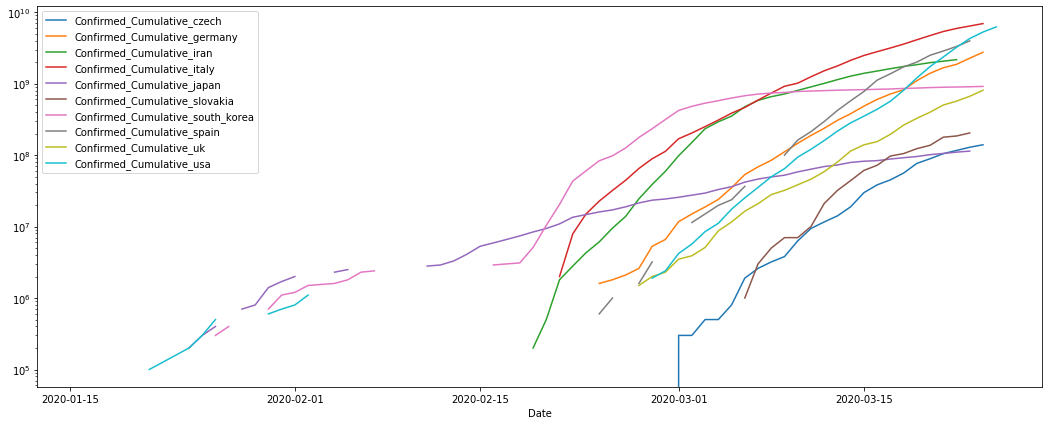

In [492]:

fig, ax = plt.subplots(figsize=(18, 7))
ax.set_yscale('log')
AxesSubplot_obj = merge_df[confirms_list].plot.line(ax=ax)

In [297]:

9300/42

221.42857142857142

In [ ]:

pandemic_df = s.load_object('pandemic_df')
pandemic_df.T.sample(6).T


---
# Create the Curve Fitter

In [9]:

tracking_df = s.load_object('us_deaths_df')
columns_list = ['Deaths_New', 'Deaths_Cumulative']
tracking_df[columns_list]

,Deaths_New,Deaths_Cumulative
Date,,
2020-02-29,1,1
2020-03-01,1,2
2020-03-02,4,6
2020-03-03,3,9
2020-03-04,2,11
2020-03-06,3,14
2020-03-07,5,19
2020-03-08,2,21
2020-03-09,5,26


In [11]:

def get_doubling_days(count_yesterday, count_today):
    growth_rate = (count_today-count_yesterday)/count_today
    doubling_time = math.log(2)/growth_rate
    
    return doubling_time

In [10]:

import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import numpy as np
import math
%matplotlib inline

method = ['lm', 'trf', 'dogbox'][1]
def fit_curve(column_name='Deaths_Cumulative',
              lba=1e-09, lbb=-49, lbc=3.8, lbd=-1.0, lbe=-1.0,
              uba=0.1, ubb=-41, ubc=8.3, ubd=1.0, ube=1.0,
              p0a=0.05, p0b=-46, p0c=3.9, p0d=0.0, p0e=0.0,
              min_x=1):
    
    # Format the data
    columns_list = [column_name]
    tracking_df[column_name] = pd.to_numeric(tracking_df[column_name])
    mask_series = (tracking_df[column_name] >= min_x)
    df = tracking_df[mask_series][columns_list].dropna(axis='index', how='any')
    
    # Fit the curve using the lower and upper bounds and a suggested starting point
    def func(x, a, b, c, d, e):

        return a * pow(x + b, c) + d * x + e
    dayofyear_data = np.array(object=[ts.dayofyear for ts in df.index])
    confirmation_data = np.array(object=[int(c) for c in df[column_name].tolist()])
    bounds_tuple = ([lba, lbb, lbc, lbd, lbe],
                    [uba, ubb, ubc, ubd, ube])
    p0_array = np.array([p0a, p0b, p0c, p0d, p0e])
    popt, pcov = curve_fit(func, dayofyear_data, confirmation_data,
                           bounds=bounds_tuple, p0=p0_array, method=method)
    
    # Plot the cumulative data
    fig = plt.figure(figsize=(12,8))
    ax = fig.add_subplot(111)
    ax.set_yscale('log')
    country_name = column_name.split('_')[-1]
    line_2d_obj = plt.plot(dayofyear_data, confirmation_data, 'b-', label='{} data'.format(country_name))
    
    # Plot the fitted curve
    def get_cumulative_confirmations(dayofyear):
        '''Get the cumulative confirmations given the day of the year'''
        #print('{} * pow({} + {}, {}) + {} * {} + {}'.format(popt[0], dayofyear, popt[1], popt[2], popt[3], dayofyear, popt[4]))
        
        return popt[0] * pow(dayofyear + popt[1], popt[2]) + popt[3] * dayofyear + popt[4]
    label_str = 'fit: cc = %3.2f * pow(doy%3.0f, %3.1f) + %3.1f * doy + %3.1f' % tuple(popt)
    line_2d_obj = plt.plot(dayofyear_data, get_cumulative_confirmations(dayofyear_data), 'r-', label=label_str)
    
    # Label the graph
    plt.xlabel('Day of Year')
    label_list = column_name.split('_')
    plt.ylabel('{} {}'.format(label_list[0], label_list[1]))
    legend_obj = plt.legend()
    
    # Get the doubling time
    doubling_time_list = []
    for i, confirms in enumerate(confirmation_data):
        if i > 0:
            doubling_time = get_doubling_days(confirmation_data[i-1], confirmation_data[i])
            doubling_time_list.append(doubling_time)
    average_doubling_time = np.array(doubling_time_list).mean()
    
    return popt, average_doubling_time, get_cumulative_confirmations

The US will have 1,310 cumulative deaths today. It is doubling every 3.8 days.
That 1.0000000000000003e-09 * pow(dayofyear-48, 7.671722341113232) + -0.08941274015985463 * dayofyear + 0.9999999999999999 curve shown in red is fitted to the data.


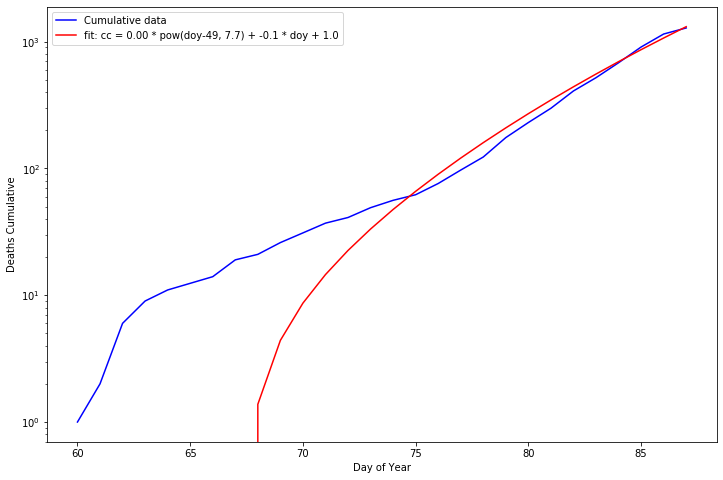

In [12]:

from datetime import datetime

popt, doubling_days, get_cumulative_deaths = fit_curve('Deaths_Cumulative')
dayofyear = pd.Timestamp(datetime.now()).dayofyear
#print(dayofyear)
confirmed_now = int(get_cumulative_deaths(dayofyear))
print('The US will have {:,} cumulative deaths today. It is doubling every {} days.'.format(confirmed_now, round(doubling_days, 1)))
formatted_str = 'That {} * pow(dayofyear{}, {}) + {} * dayofyear + {} curve shown in red is fitted to the data.'
print(formatted_str.format(popt[0], int(popt[1]), popt[2], popt[3], popt[4]))

In [ ]:

# Hall of Fame
lba = 4.110281698247205e-31
uba = 4.110281698247205e-29
p0a = 4.110281698247205e-30

lbb = -513.9398352299962
ubb = -5.139398352299962
p0b = -51.39398352299962

lbc = 2.2185491179655665
ubc = 221.85491179655662
p0c = 22.185491179655664

lbd = 0.3701748485216486
ubd = 37.017484852164856
p0d = 3.701748485216486

lbe = -2165.504631099008
ube = -21.65504631099008
p0e = -216.5504631099008

In [63]:

def get_lb_ub(p0):
    if p0 < 0:
        uba = math.copysign(abs(p0)/10, p0)
        lba = math.copysign(abs(p0)*10, p0)
    else:
        lba = math.copysign(abs(p0)/10, p0)
        uba = math.copysign(abs(p0)*10, p0)
    
    return lba, uba

In [101]:

def format_the_data(column_name, min_x):
    columns_list = [column_name]
    tracking_df[column_name] = pd.to_numeric(tracking_df[column_name])
    mask_series = (tracking_df[column_name] >= min_x)
    df = tracking_df[mask_series][columns_list].dropna(axis='index', how='any')
    
    return df

In [95]:

def get_average_doubling(confirmation_data):
    doubling_time_list = []
    for i, confirms in enumerate(confirmation_data):
        if i > 0:
            doubling_time = get_doubling_days(confirmation_data[i-1], confirmation_data[i])
            doubling_time_list.append(doubling_time)
    average_doubling_time = np.array(doubling_time_list).mean()
    
    return average_doubling_time

In [108]:

import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import numpy as np
import math
%matplotlib inline

method = ['lm', 'trf', 'dogbox'][1]
def fit_spike_curve(column_name='Deaths_New',
                    lba=1e-09, lbb=-49, lbc=3.8,
                    uba=0.1, ubb=-41, ubc=8.3,
                    p0a=0.05, p0b=-46, p0c=3.9,
                    min_x=1):
    
    # Format the data
    df = format_the_data(column_name, min_x)
    
    # Fit the curve using the lower and upper bounds and a suggested starting point
    def func(x, a, b, c):

        return a*np.exp(-np.abs(b-x)) + a*np.exp(-np.abs(-b-x)) + c
    dayofyear_data = np.array(object=[ts.dayofyear for ts in df.index])
    confirmation_data = np.array(object=[int(c) for c in df[column_name].tolist()])
    bounds_tuple = ([lba, lbb, lbc],
                    [uba, ubb, ubc])
    p0_array = np.array([p0a, p0b, p0c])
    popt, pcov = curve_fit(func, dayofyear_data, confirmation_data,
                           bounds=bounds_tuple, p0=p0_array, method=method)
    
    # Plot the cumulative data
    fig = plt.figure(figsize=(12,8))
    ax = fig.add_subplot(111)
    ax.set_yscale('log')
    country_name = column_name.split('_')[-1]
    line_2d_obj = plt.plot(dayofyear_data, confirmation_data, 'b-', label='{} data'.format(country_name))
    
    # Plot the fitted curve
    def get_spike_curve(dayofyear):
        '''Get the cumulative confirmations given the day of the year'''
        #fitted_str = '{}*math.exp(-abs({}-{})) + {}*math.exp(-abs(-{}-{})) + {}'
        #print(fitted_str.format(popt[0], popt[1], dayofyear, popt[0], popt[1], dayofyear, popt[2]))
        
        return popt[0]*np.exp(-np.abs(popt[1]-dayofyear)) + popt[0]*np.exp(-np.abs(-popt[1]-dayofyear)) + popt[2]
    fitted_str = 'fit: cc = {}*e^(-|{}-doy|) + {}*e^(-|-{}-doy|) + {}'
    label_str = fitted_str.format(round(popt[0], 1), round(popt[1], 1), round(popt[0], 1), round(popt[1], 1), round(popt[2], 1))
    line_2d_obj = plt.plot(dayofyear_data, get_spike_curve(dayofyear_data), 'r-', label=label_str)
    
    # Label the graph
    plt.xlabel('Day of Year')
    label_list = column_name.split('_')
    plt.ylabel('{} {}'.format(label_list[0], label_list[1]))
    legend_obj = plt.legend()
    
    # Get the doubling time
    average_doubling_time = get_average_doubling(confirmation_data)
    
    return popt, average_doubling_time, get_spike_curve

In [242]:

for Date, row_series in tracking_df.iterrows():
    Deaths_Cumulative = int(13939 - math.exp(row_series.Deaths_Cumulative) + math.exp(1))
    doy = 2275 - Date.dayofyear + 60
    print('{},{}'.format(doy, Deaths_Cumulative))

2275,13939
2274,13934
2273,13538
2272,5838
2271,-45932
2269,-1188662
2268,-178468359
2267,-1318801792
2266,-195729595487
2265,-29048849651305
2264,-11719142372788670
2263,-639843493530040960
2262,-1907346572495099789312
2261,-2091659496012996103110656
2260,-843835666874145383188004864
2259,-1014800388113888746146344200044544
2258,-1338334719204269538704786735170027538874368
2257,-261951731874906258110461086864248710658641925802819584
2256,-10035391806143294731975669366983223436684697856246987384664805423350991028224
2255,-7722018499983836127530809622882122887874694314704808148746908126846600538883905347984100737817772032
2254,-2628788263662479581254117861646297281012370367049287304325934274605052152842881661006954005021093398083615389283790941919341707264
2253,-1556498177579872066015377543904995829085706778326869044757027791433668209094719870887594523763668302383499806878791121458835193175516218213373848722912835496838659788218482819072
2252,-2505163686563976150109020384927822433259374

OverflowError: math range error

In [240]:

math.exp(1)

2.718281828459045

In [137]:

lba = 24.1
uba = 2410
p0a = 241

lbb = 0.85
ubb = 850
p0b = 85

lbc = 1
ubc = 100
p0c = 10

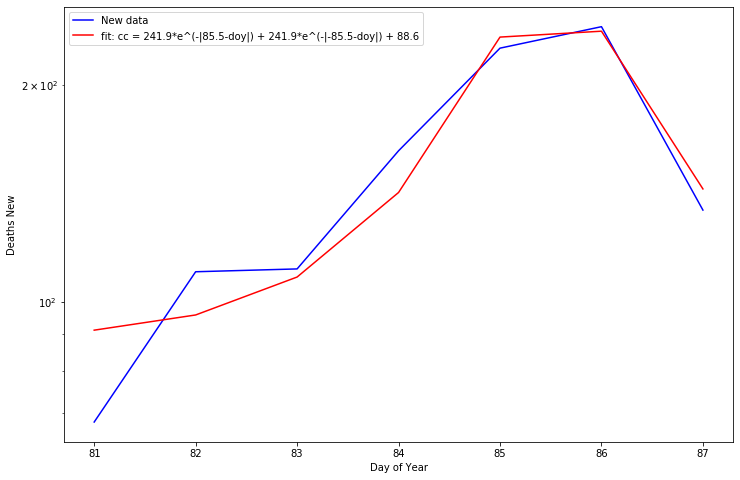

In [232]:

column_name = 'Deaths_New'
p0a = popt[0]
lba, uba = get_lb_ub(p0a)
p0b = popt[1]
lbb, ubb = get_lb_ub(p0b)
p0c = popt[2]
lbc, ubc = get_lb_ub(p0c)
popt, doubling_days, get_results = fit_spike_curve(column_name,
                                                   lba=lba, lbb=lbb, lbc=lbc,
                                                   uba=uba, ubb=ubb, ubc=ubc,
                                                   p0a=p0a, p0b=p0b, p0c=p0c,
                                                   min_x=60)

In [230]:

mask_series = (MAR26_df.index == 'United States')
date_obj = datetime(year=2020, month=3, day=26)
dayofyear = pd.Timestamp(date_obj).dayofyear
print(dayofyear)
MAR26_df[mask_series]

86


,Confirmed_Cumulative,Confirmed_New,Deaths_Cumulative,Deaths_New,Transmission_Classification,Days_Since_Last
United States,63570,11656,884,211,Local transmission,0


In [233]:

new_deaths = int(get_results(dayofyear))
print('The US will have {:,} new deaths on {}.'.format(new_deaths, date_obj.strftime('%b %d, %Y')))

The US will have 237 new deaths on Mar 26, 2020.


In [160]:

print('''
lba = {}
uba = {}
p0a = {}'''.format(lba, uba, p0a))
print('''
lbb = {}
ubb = {}
p0b = {}'''.format(lbb, ubb, p0b))
print('''
lbc = {}
ubc = {}
p0c = {}'''.format(lbc, ubc, p0c))


lba = 24.189241753373892
uba = 2418.924175337389
p0a = 241.89241753373892

lbb = 8.551510604281356
ubb = 855.1510604281356
p0b = 85.51510604281356

lbc = 8.859670423601461
ubc = 885.9670423601461
p0c = 88.59670423601462


In [110]:

method = ['lm', 'trf', 'dogbox'][1]
def fit_curve_sans_graph(column_name='Deaths_Cumulative',
                         lba=1e-09, lbb=-49, lbc=3.8, lbd=-1.0, lbe=-1.0,
                         uba=0.1, ubb=-41, ubc=8.3, ubd=1.0, ube=1.0,
                         p0a=0.05, p0b=-46, p0c=3.9, p0d=0.0, p0e=0.0,
                         min_x=1):
    
    # Format the data
    df = format_the_data(column_name)
    
    # Fit the curve using the lower and upper bounds and a suggested starting point
    def func(x, a, b, c, d, e):

        return a * pow(x + b, c) + d * x + e
    dayofyear_data = np.array(object=[ts.dayofyear for ts in df.index])
    confirmation_data = np.array(object=[int(c) for c in df[column_name].tolist()])
    bounds_tuple = ([lba, lbb, lbc, lbd, lbe],
                    [uba, ubb, ubc, ubd, ube])
    p0_array = np.array([p0a, p0b, p0c, p0d, p0e])
    popt, pcov = curve_fit(func, dayofyear_data, confirmation_data,
                           bounds=bounds_tuple, p0=p0_array, method=method)
    
    # Don't plot the fitted curve
    def get_cumulative_confirmations(dayofyear):
        '''Get the cumulative confirmations given the day of the year'''
        #print('{} * pow({} + {}, {}) + {} * {} + {}'.format(popt[0], dayofyear, popt[1], popt[2], popt[3], dayofyear, popt[4]))
        
        return popt[0] * pow(dayofyear + popt[1], popt[2]) + popt[3] * dayofyear + popt[4]
    
    # Get the doubling time
    average_doubling_time = get_average_doubling(confirmation_data)
    
    return popt, average_doubling_time, get_cumulative_confirmations

In [79]:

def overfit_curve(popt, doubling_days=None, get_results=None, column_name='Deaths_Cumulative'):
    p0a = popt[0]
    lba, uba = get_lb_ub(p0a)
    p0b = popt[1]
    lbb, ubb = get_lb_ub(p0b)
    p0c = popt[2]
    lbc, ubc = get_lb_ub(p0c)
    p0d = popt[3]
    lbd, ubd = get_lb_ub(p0d)
    p0e = popt[4]
    lbe, ube = get_lb_ub(p0e)
    try:
        popt, doubling_days, get_results = fit_curve_sans_graph(column_name,
                                                                lba=lba, lbb=lbb, lbc=lbc, lbd=lbd, lbe=lbe,
                                                                uba=uba, ubb=ubb, ubc=ubc, ubd=ubd, ube=ube,
                                                                p0a=p0a, p0b=p0b, p0c=p0c, p0d=p0d, p0e=p0e,
                                                                min_x=60)
    except ValueError as e:
        message = str(e).strip()
        print(message)
        print('''
lba = {}
uba = {}
p0a = {}'''.format(lba, uba, p0a))
        print('''
lbb = {}
ubb = {}
p0b = {}'''.format(lbb, ubb, p0b))
        print('''
lbc = {}
ubc = {}
p0c = {}'''.format(lbc, ubc, p0c))
        print('''
lbd = {}
ubd = {}
p0d = {}'''.format(lbd, ubd, p0d))
        print('''
lbe = {}
ube = {}
p0e = {}'''.format(lbe, ube, p0e))
    
    return popt, doubling_days, get_results

In [90]:

for i in range(10):
    popt, doubling_days, get_results = overfit_curve(popt, doubling_days, get_results, column_name='Deaths_Cumulative')

array must not contain infs or NaNs

lba = 0.12309943329721984
uba = 12.309943329721984
p0a = 1.2309943329721984

lbb = -738.6649714789803
ubb = -7.386649714789803
p0b = -73.86649714789803

lbc = 0.26901478172140514
ubc = 26.901478172140514
p0c = 2.6901478172140516

lbd = 0.08402165631346971
ubd = 8.402165631346971
p0d = 0.8402165631346971

lbe = -3.3265129610783047e-13
ube = -3.3265129610783046e-15
p0e = -3.3265129610783047e-14


In [91]:

p0a = popt[0]
lba, uba = get_lb_ub(p0a)
p0b = popt[1]
lbb, ubb = get_lb_ub(p0b)
p0c = popt[2]
lbc, ubc = get_lb_ub(p0c)
p0d = popt[3]
lbd, ubd = get_lb_ub(p0d)
p0e = popt[4]
lbe, ube = get_lb_ub(p0e)
popt, doubling_days, get_cumulative_deaths = fit_curve('Deaths_Cumulative',
                                                       lba=lba, lbb=lbb, lbc=lbc, lbd=lbd, lbe=lbe,
                                                       uba=uba, ubb=ubb, ubc=ubc, ubd=ubd, ube=ube,
                                                       p0a=p0a, p0b=p0b, p0c=p0c, p0d=p0d, p0e=p0e,
                                                       min_x=1)
dayofyear = pd.Timestamp(datetime.now()).dayofyear
#dayofyear = pd.Timestamp(datetime(year=2020, month=3, day=16)).dayofyear
confirmed_now = int(get_cumulative_deaths(dayofyear))
print('The US will have {:,} cumulative confirmed cases today. It is doubling every {} days.'.format(confirmed_now, round(doubling_days, 1)))
formatted_str = 'That {} * pow(dayofyear{}, {}) + {} * dayofyear + {} curve shown in red is (over)fitted to the data.'
print(formatted_str.format(popt[0], popt[1], popt[2], popt[3], popt[4]))

ValueError: Residuals are not finite in the initial point.

In [92]:

print(lba, popt[0], uba)
print(lbb, popt[1], ubb)
print(lbc, popt[2], ubc)
print(lbd, popt[3], ubd)
print(lbe, popt[4], ube)
dayofyear = pd.Timestamp(datetime.now()).dayofyear
confirmed_now = int(get_cumulative_deaths_usa(dayofyear))
print('The US will have {:,} cumulative confirmed deaths today. It is doubling every {} days.'.format(confirmed_now, round(doubling_days, 1)))
formatted_str = 'That {} * pow(dayofyear{}, {}) + {} * dayofyear + {} curve shown in red is (over)fitted to the data.'
print(formatted_str.format(popt[0], popt[1], popt[2], popt[3], popt[4]))

0.12309943329721984 1.2309943329721984 12.309943329721984
-738.6649714789803 -73.86649714789803 -7.386649714789803
0.26901478172140514 2.6901478172140516 26.901478172140514
0.08402165631346971 0.8402165631346971 8.402165631346971
-3.3265129610783047e-13 -3.3265129610783047e-14 -3.3265129610783046e-15
The US will have 1,340 cumulative confirmed deaths today. It is doubling every 3.3 days.
That 1.2309943329721984 * pow(dayofyear-73.86649714789803, 2.6901478172140516) + 0.8402165631346971 * dayofyear + -3.3265129610783047e-14 curve shown in red is (over)fitted to the data.


In [ ]:

tracking_df.columns

In [ ]:

def get_lb_ub(p0):
    if p0 < 0:
        uba = math.copysign(abs(p0)/10, p0)
        lba = math.copysign(abs(p0)*10, p0)
    else:
        lba = math.copysign(abs(p0)/10, p0)
        uba = math.copysign(abs(p0)*10, p0)
    
    return lba, uba

p0a = popt[0]
lba, uba = get_lb_ub(p0a)
print('''
lba = {}
uba = {}
p0a = {}'''.format(lba, uba, p0a))

p0b = popt[1]
lbb, ubb = get_lb_ub(p0b)
print('''
lbb = {}
ubb = {}
p0b = {}'''.format(lbb, ubb, p0b))

p0c = popt[2]
lbc, ubc = get_lb_ub(p0c)
print('''
lbc = {}
ubc = {}
p0c = {}'''.format(lbc, ubc, p0c))

p0d = popt[3]
lbd, ubd = get_lb_ub(p0d)
print('''
lbd = {}
ubd = {}
p0d = {}'''.format(lbd, ubd, p0d))

p0e = popt[4]
lbe, ube = get_lb_ub(p0e)
print('''
lbe = {}
ube = {}
p0e = {}'''.format(lbe, ube, p0e))

In [ ]:

lba = 3.5898673196110995e-29
uba = 3.589867319611099e-27
p0a = 3.5898673196110993e-28

lbb = -258.0043216718908
ubb = -2.580043216718908
p0b = -25.80043216718908

lbc = 1.794478077861036
ubc = 179.44780778610362
p0c = 17.94478077861036

lbd = 4.482007640229286
ubd = 448.2007640229285
p0d = 44.820076402292855

lbe = -32017.1490577167
ube = -320.171490577167
p0e = -3201.7149057716697

In [ ]:

column_name = 'Confirmed_New_usa'
popt, doubling_days, get_new_confirmations_usa = fit_curve(column_name=column_name,
                                                           lba=lba, lbb=lbb, lbc=lbc, lbd=lbd, lbe=lbe,
                                                           uba=uba, ubb=ubb, ubc=ubc, ubd=ubd, ube=ube,
                                                           p0a=p0a, p0b=p0b, p0c=p0c, p0d=p0d, p0e=p0e,
                                                           min_x=100)
dayofyear = pd.Timestamp(datetime.now()).dayofyear
confirmed_now = int(get_new_confirmations_usa(dayofyear))
word_list = column_name.lower().split('_')
formatted_str = 'The US will have {:,} {} {} cases today. It is doubling every {} days.'
print(formatted_str.format(confirmed_now, word_list[0], word_list[1], round(doubling_days, 1)))
formatted_str = 'That {} * pow(dayofyear{}, {}) + {} * dayofyear + {} curve shown in red is (over)fitted to the data.'
print(formatted_str.format(popt[0], popt[1], popt[2], popt[3], popt[4]))

In [ ]:

import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import numpy as np
import math
%matplotlib inline

#tracking_df = s.load_object('tracking_df')
method = ['lm', 'trf', 'dogbox'][1]
def fit_sigmoid_curve(column_name='Confirmed_New_usa',
                      lba=1e-09, lbb=-49, lbc=3.8,
                      uba=0.1, ubb=-41, ubc=8.3,
                      p0a=0.05, p0b=-46, p0c=3.9,
                      min_x=100):
    
    # Format the data
    columns_list = [column_name]
    tracking_df[column_name] = pd.to_numeric(tracking_df[column_name])
    mask_series = (tracking_df[column_name] >= min_x)
    df = tracking_df[mask_series][columns_list].dropna(axis='index', how='any')
    
    # Fit the curve using the lower and upper bounds and a suggested starting point
    def sigmoid(x, a, b, c):
        #print('{} / (1 + np.exp(-1*{}*np.subtract(np.array({}), {})))'.format(a, b, x, c))
        
        return a / (1 + np.exp(-1*b*np.subtract(x, c)))
    dayofyear_data = np.array(object=[ts.dayofyear for ts in df.index])
    confirmation_data = np.array(object=[int(c) for c in df[column_name].tolist()])
    bounds_tuple = ([lba, lbb, lbc],
                    [uba, ubb, ubc])
    p0_array = np.array([p0a, p0b, p0c])
    popt, pcov = curve_fit(sigmoid, dayofyear_data, confirmation_data,
                           bounds=bounds_tuple, p0=p0_array, method=method)
    
    # Plot the cumulative data
    fig = plt.figure(figsize=(18, 4))
    ax = fig.add_subplot(111)
    #ax.set_yscale('log')
    country_name = column_name.split('_')[-1]
    line_2d_obj = plt.plot(dayofyear_data, confirmation_data, 'b-', label='{} data'.format(country_name))
    
    # Plot the fitted curve
    def get_cumulative_confirmations(dayofyear):
        '''Get the cumulative confirmations given the day of the year'''
        #print('{} / (1 + np.exp(-{}({}-{})))'.format(popt[0], popt[1], dayofyear, popt[2]))
        
        return popt[0] / (1 + np.exp(-1*popt[1]*np.subtract(dayofyear, popt[2])))
    label_str = 'fit: cc = %3.0f / (1 + np.exp(-%3.1f(doy-%3.1f)))' % tuple(popt)
    line_2d_obj = plt.plot(dayofyear_data, get_cumulative_confirmations(dayofyear_data), 'r-', label=label_str)
    
    # Label the graph
    plt.xlabel('Day of Year')
    label_list = column_name.split('_')
    plt.ylabel('{} {}'.format(label_list[0], label_list[1]))
    legend_obj = plt.legend()
    
    # Get the doubling time
    doubling_time_list = []
    for i, confirms in enumerate(confirmation_data):
        if i > 0:
            growth_rate = (confirmation_data[i]-confirmation_data[i-1])/confirmation_data[i]
            doubling_time = math.log(2)/growth_rate
            if (doubling_time != np.inf) and (doubling_time > 0):
                doubling_time_list.append(doubling_time)
    average_doubling_time = np.array(doubling_time_list).mean()
    
    return popt, average_doubling_time, get_cumulative_confirmations

In [ ]:

column_name = 'Confirmed_New_usa'
popt, doubling_days, get_new_confirmations_usa = fit_sigmoid_curve(column_name=column_name, lba=lba, lbb=lbb, lbc=lbc, uba=uba, ubb=ubb, ubc=ubc,
                                                                   p0a=p0a, p0b=p0b, p0c=p0c, min_x=1)

In [ ]:

p0a = popt[0]
lba, uba = get_lb_ub(p0a)
print('''
lba = {}
uba = {}
p0a = {}'''.format(lba, uba, p0a))

p0b = popt[1]
lbb, ubb = get_lb_ub(p0b)
print('''
lbb = {}
ubb = {}
p0b = {}'''.format(lbb, ubb, p0b))

p0c = popt[2]
lbc, ubc = get_lb_ub(p0c)
print('''
lbc = {}
ubc = {}
p0c = {}'''.format(lbc, ubc, p0c))

In [ ]:

column_name = 'Deaths_New_usa'
popt, doubling_days, get_new_deaths_usa = fit_sigmoid_curve(column_name=column_name, lba=lba, lbb=lbb, lbc=lbc, uba=uba, ubb=ubb,
                                                            ubc=ubc, p0a=p0a, p0b=p0b, p0c=p0c, min_x=1)

In [ ]:

df.Deaths_New.unique()

In [ ]:

from scipy.stats import pearsonr
import seaborn as sns

usa_df = s.load_object('usa_df')
qr_column = 'Deaths_New'
qe_column = 'doy'
columns_list = [qr_column, 'Date']
df = usa_df[columns_list].dropna(axis='index', how='any')
df[qe_column] = df.Date.map(lambda ts: ts.dayofyear)
columns_list = [qe_column, qr_column]
df = df[columns_list]
df[qr_column] = pd.to_numeric(df[qr_column]).map(lambda x: math.log(x))
facet_grid = sns.lmplot(x=qe_column, y=qr_column, data=df)
set_list = facet_grid.set(xlabel='Day of Year',
                             ylabel='Logarithm of the day`s Coronavirus Deaths',
                             title='Association Between Time Passing and the Logarithm of New Deaths')
set_list = facet_grid.fig.set(figheight=10, figwidth=10)
pearsonr_tuple = pearsonr(df[qe_column], df[qr_column])
pearson_r = pearsonr_tuple[0]
pearsonr_statement = str('%.2f' % pearson_r)
coefficient_of_determination_statement = str('%.2f' % pearson_r**2)
p_value = pearsonr_tuple[1]
if p_value < 0.0001:
    pvalue_statement = '<0.0001'
else:
    pvalue_statement = '=' + str('%.4f' % p_value)
set_list = facet_grid.fig.text(0.135, 0.86, r'$r^2=' + coefficient_of_determination_statement + ',\ p' + pvalue_statement + '$')

In [ ]:

from scipy.stats import pearsonr
import seaborn as sns

usa_df = s.load_object('usa_df')
qr_column = 'Deaths_New'
qe_column = 'doy'
columns_list = [qr_column, 'Date']
df = usa_df[columns_list].dropna(axis='index', how='any')
df[qe_column] = df.Date.map(lambda ts: ts.dayofyear)
columns_list = [qe_column, qr_column]
df = df[columns_list]
df[qr_column] = pd.to_numeric(df[qr_column])
facet_grid = sns.lmplot(x=qe_column, y=qr_column, data=df, logx=False)
facet_grid.ax.set_yscale('log')
set_list = facet_grid.set(xlabel='Day of Year',
                             ylabel='The day`s Coronavirus Deaths',
                             title='Association Between Time Passing and New Deaths')
set_list = facet_grid.fig.set(figheight=10, figwidth=10)
pearsonr_tuple = pearsonr(df[qe_column], df[qr_column])
pearson_r = pearsonr_tuple[0]
pearsonr_statement = str('%.2f' % pearson_r)
coefficient_of_determination_statement = str('%.2f' % pearson_r**2)
p_value = pearsonr_tuple[1]
if p_value < 0.0001:
    pvalue_statement = '<0.0001'
else:
    pvalue_statement = '=' + str('%.4f' % p_value)
set_list = facet_grid.fig.text(0.135, 0.86, r'$r^2=' + coefficient_of_determination_statement + ',\ p' + pvalue_statement + '$')

In [ ]:

print(type(axes_subplot1))
print(['facet_grid.{}'.format(fn) for fn in dir(axes_subplot1) if not fn.startswith('_')])

In [ ]:

sns.lmplot?

In [ ]:

#date_obj = datetime(year=2020, month=12, day=31)
#dayofyear = pd.Timestamp(date_obj).dayofyear
date_obj = datetime.now()
dayofyear = pd.Timestamp(date_obj).dayofyear
confirmed_now = int(get_new_deaths_usa(dayofyear))
word_list = column_name.lower().split('_')
formatted_str = 'The US will have {:,} {} {} on {}. It is doubling every {} days.'
print(formatted_str.format(confirmed_now, word_list[0], word_list[1], date_obj.strftime('%b %d, %Y'), round(doubling_days, 1)))
formatted_str = 'That {} / (1 + math.exp(-1*{}*(dayofyear-{}))) curve shown in red is (over)fitted to the data.'
print(formatted_str.format(popt[0], popt[1], popt[2]))

In [ ]:

lba = 6166330.3878130205
uba = 616633038.7813021/4
p0a = 61663303.878130205

lbb = 0.039285826964592
ubb = 3.9285826964591997
p0b = 0.39285826964591997

lbc = 10.381717623034424
ubc = 1038.1717623034424
p0c = 103.81717623034424

In [ ]:

column_description_dict = s.load_object('column_description_dict')

In [ ]:

def get_column_description(column_name):
    if column_name in column_description_dict:
        column_description = column_description_dict[column_name]
    else:
        column_description = re.sub('^pf_', 'Personal Freedom:_', str(column_name), 1)
        column_description = re.sub('^hf_', 'Human Freedom:_', str(column_description), 1)
        column_description = re.sub('^ef_', 'Economic Freedom:_', str(column_description), 1)
        column_list = column_description.split('_')
        descr_list = []
        for word in column_list:
            descr_list.append(word[0].upper()+word[1:])
        column_description = ' '.join(descr_list)
        column_description_dict[column_name] = column_description
        s.store_objects(column_description_dict=column_description_dict)
    
    return column_description

In [ ]:

for column_name in pandemic_df.columns:
    print(column_name, get_column_description(column_name=column_name))

In [ ]:

svg_dir = os.path.join(s.saves_folder, 'svg')
os.makedirs(name=svg_dir, exist_ok=True)

In [ ]:

def show_linear_scatterplot(merged_df, columns_list, ev_min_str=None, ev_max_str=None, rv_min_str=None, rv_max_str=None):
    ev_column_name = columns_list[0]
    rv_column_name = columns_list[1]
    explanatory_variable = get_column_description(ev_column_name)
    response_variable = get_column_description(rv_column_name)
    if (ev_min_str is None):
        ev_min_str = 'minimum {}'.format(explanatory_variable)
    if (ev_max_str is None):
        ev_max_str = 'maximum {}'.format(explanatory_variable)
    if (rv_min_str is None):
        rv_min_str = 'minimum {}'.format(response_variable)
    if (rv_max_str is None):
        rv_max_str = 'maximum {}'.format(response_variable)
    
    df = merged_df.copy()
    columns_list = [ev_column_name, rv_column_name]
    df = df[columns_list].dropna()
    ev_max = df[ev_column_name].max()
    ev_min = df[ev_column_name].min()
    rv_min = df[rv_column_name].min()
    rv_max = df[rv_column_name].max()
    ev_max_labeled = False
    ev_min_labeled = False
    rv_min_labeled = False
    rv_max_labeled = False
    
    # First order (linear) scatterplot
    fig1_fig = plt.figure(figsize=(12,8))
    merge_axes_subplot = plt.scatter(x=df[ev_column_name].tolist(), y=df[rv_column_name].tolist(), s=None, c=None, marker=None, cmap=None,
                                     norm=None, vmin=None, vmax=None, alpha=None, linewidths=None, verts=None, edgecolors=None,
                                     plotnonfinite=False, data=df)
    xlabel_text = plt.xlabel('{}'.format(explanatory_variable))
    ylabel_text = plt.ylabel('{}'.format(response_variable))
    
    # Add annotations
    for label, x, y in zip(df.index, df[ev_column_name], df[rv_column_name]):
        if (x == ev_min):
            if not ev_min_labeled:
                ev_min_labeled = True
                annotation = plt.annotate('{} ({})'.format(label, ev_min_str), xy=(x, y), xytext=ev_min_xytext, **kwargs)
        elif (x == ev_max):
            if not ev_max_labeled:
                ev_max_labeled = True
                annotation = plt.annotate('{} ({})'.format(label, ev_max_str), xy=(x, y), xytext=ev_max_xytext, **kwargs)
        elif (y == rv_min):
            if not rv_min_labeled:
                rv_min_labeled = True
                annotation = plt.annotate('{} ({})'.format(label, rv_min_str), xy=(x, y), xytext=rv_min_xytext, **kwargs)
        elif (y == rv_max):
            if not rv_max_labeled:
                rv_max_labeled = True
                annotation = plt.annotate('{} ({})'.format(label, rv_max_str), xy=(x, y), xytext=rv_max_xytext, **kwargs)
        elif (label == 'SARS'):
            annotation = plt.annotate('{}'.format(label), xy=(x, y), xytext=(50, -20), **kwargs)
        elif ('Kong' in label):
            annotation = plt.annotate('{}'.format(label), xy=(x, y), xytext=(-65, 120), **kwargs)
        elif ('Swine' in label):
            annotation = plt.annotate('{}'.format(label), xy=(x, y), xytext=(-50, 100-2.7842095), **kwargs)
        elif ('Seasonal' in label):
            annotation = plt.annotate('{}'.format(label), xy=(x, y), xytext=(-25, 70-1.9397546), **kwargs)
        elif ('Spanish' in label):
            annotation = plt.annotate('{}'.format(label), xy=(x, y), xytext=(-59, 128), **kwargs)
        elif ('19' in label):
            annotation = plt.annotate('{}'.format(label), xy=(x, y), xytext=(-85, 25), **red_kwargs)
        '''else:
            annotation = plt.annotate('{}'.format(label), xy=(x, y), xytext=ev_min_xytext, **kwargs)'''
    
    # Add r-squared
    x = df[ev_column_name].values
    y = df[rv_column_name].values
    plt.text(17.4, 34.4, r'$r^2 = {0:.2}$'.format(stats.pearsonr(x, y)[0] ** 2), fontsize=20, alpha=0.25,
             horizontalalignment='center', verticalalignment='center')
    plt.suptitle(t='Relative Deadliness and Infectiousness of the Wuhan Flu Pandemic', x=0.5, y=0.91)
    left, right = plt.xlim()
    bottom, top = plt.ylim()
    file_path = os.path.join(svg_dir, 'pandemic.svg')
    plt.savefig(file_path)
    with open(file_path, 'r') as f:
        xml_str = f.read()
        d_regex = re.compile('d="([^"\r\n]+)[\r\n]+')
        while d_regex.search(xml_str):
            xml_str = d_regex.sub(r'd="\g<1>', xml_str)
        with open(file_path, 'w') as f:
            print(xml_str.strip(), file=f)
    
    return file_path, left, right, bottom, top

In [ ]:

#pandemic_df = s.load_object('pandemic_df')
kwargs = dict(textcoords='offset points', ha='left', va='bottom',
              bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
              arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))
red_kwargs = dict(textcoords='offset points', ha='left', va='bottom',
                  bbox=dict(boxstyle='round,pad=0.5', fc='pink', alpha=0.5),
                  arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

ev_column_name = 'R0_high'
rv_column_name = 'CFR_high'

ev_min_str = 'least infectious'
ev_max_str = 'most infectious'
rv_min_str = 'least deadly'
rv_max_str = 'most deadly'
ev_min_xytext = (50, -10)
ev_max_xytext = (-150, -10)
rv_min_xytext = (20, -5)
rv_max_xytext = (100, -50)
columns_list = [ev_column_name, rv_column_name]
file_path, left, right, bottom, top = show_linear_scatterplot(pandemic_df, columns_list, ev_min_str=ev_min_str,
                                                              ev_max_str=ev_max_str, rv_min_str=rv_min_str,
                                                              rv_max_str=rv_max_str)
!start %windir%\explorer.exe "{os.path.abspath(os.path.dirname(file_path))}"

In [ ]:

import matplotlib

columns_list = ['R0_high', 'R0_low', 'CFR_high', 'CFR_low']
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)
mask_series = (pandemic_df.index == 'Rubella')
for Disease, row_series in pandemic_df[columns_list].iterrows():
    R0_high = row_series['R0_high']
    R0_low = row_series['R0_low']
    CFR_high = row_series['CFR_high']
    CFR_low = row_series['CFR_low']
    rect = matplotlib.patches.Rectangle((R0_low, CFR_low), R0_high-R0_low, CFR_high-CFR_low, color='black', alpha=0.5)
    ax.add_patch(rect)
    #annotation = plt.annotate('{}'.format(Disease), xy=(int((R0_high+R0_low)/2), int((CFR_high+CFR_low)/2)), xytext=(-85, 20), **red_kwargs)
plt.xlim(left, right)
bottom, top = plt.ylim(bottom, top)
xlabel_text = plt.xlabel('Basic Reproduction Number')
ylabel_text = plt.ylabel('Case Fatality Ratio')

In [ ]:

Disease, R0_high, R0_low, CFR_high, CFR_low

In [ ]:

merge_axes_subplot = plt.scatter(x=df[ev_column_name].tolist(), y=df[rv_column_name].tolist(), s=None, c=None, marker=None, cmap=None,
                                 norm=None, vmin=None, vmax=None, alpha=None, linewidths=None, verts=None, edgecolors=None,
                                 plotnonfinite=False, data=df)